# Mini version of mutrans.py model

In [1]:
import os
import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro.distributions as dist
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyrocov import mutrans, pangolin, stats

logging.basicConfig(format="%(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

In [3]:
def load_data_subset(*args, **kwargs):
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset = mutrans.subset_gisaid_data(dataset, *args, **kwargs)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset

queries = ["England", "USA / California", "Sao Paulo"]
dataset = load_data_subset(
    queries,
    max_strains=50,
)
locals().update(dataset)

values, indices = weekly_strains.sum([0,-1]).sort(0, descending=True)
location_id_inv = list(location_id)
for v, i in zip(values.tolist(), indices.tolist()):
    print("{: >7d} {}".format(int(v), location_id_inv[i]))
print()
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

Selected 3/932 places, 50/1279 strains, 189/2320 mutations, 356307/1766964 samples
Loaded 499 x 3618 daily case data, totaling 205496352.0
Joining GISAID and JHU region codes
Matching 3 GISAID regions to 3618 JHU fuzzy regions


 302901 Europe / United Kingdom / England
  47799 North America / USA / California
   5607 South America / Brazil / Sao Paulo

daily_cases 	Tensor of shape (499, 3)
features 	Tensor of shape (50, 189)
lineage_id 	dict of size 50
lineage_id_inv 	list of size 50
local_time 	Tensor of shape (40, 3)
location_id 	dict of size 3
mutations 	list of size 189
weekly_cases 	Tensor of shape (40, 3)
weekly_strains 	Tensor of shape (40, 3, 50)


In [21]:
fit = mutrans.fit_svi(
    dataset,
    model_type="",
    guide_type="",
    init_data={},
    cond_data={},
    # cond_data={"feature_scale": 0.1, "noise_scale": 0.001},
    learning_rate=0.05,
    learning_rate_decay=1,
    num_steps=2001,
    clip_norm=10.0,
    rank=10,
    log_every=100,
    seed=20210319,
)

Fitting  guide via SVI
init stddev = 3.98
Fitting model with latent variables of shapes:
          feature_scale        ()
          logits_scale         ()
          rate_coef            (189,)
          strain_scale         (50,)
          place_scale          (3,)
          rate_decentered      (3, 50)
          init                 (3, 50)
          logits_decentered    (40, 3, 50)
Training guide with 15732 parameters. Latent variables:
step    0 L=13608.6 FS=0.951 LS=0.00105
step  100 L=36.0326 FS=0.939 LS=0.000621
step  200 L=31.4635 FS=0.849 LS=0.000115
step  300 L=28.8067 FS=0.782 LS=6.56e-05
step  400 L=26.5969 FS=0.8 LS=5.78e-05
step  500 L=24.4399 FS=0.753 LS=5.71e-05
step  600 L=22.5734 FS=0.702 LS=5.46e-05
step  700 L=21.3861 FS=0.673 LS=7.84e-05
step  800 L=20.1157 FS=0.636 LS=0.000104
step  900 L=19.4489 FS=0.624 LS=0.000148
step 1000 L=18.8003 FS=0.583 LS=0.000223
step 1100 L=18.4949 FS=0.562 LS=0.000307
step 1200 L=17.9661 FS=0.543 LS=0.000376
step 1300 L=17.6824 FS=0.

England matched 1 regions
USA / California matched 1 regions
Sao Paulo matched 1 regions


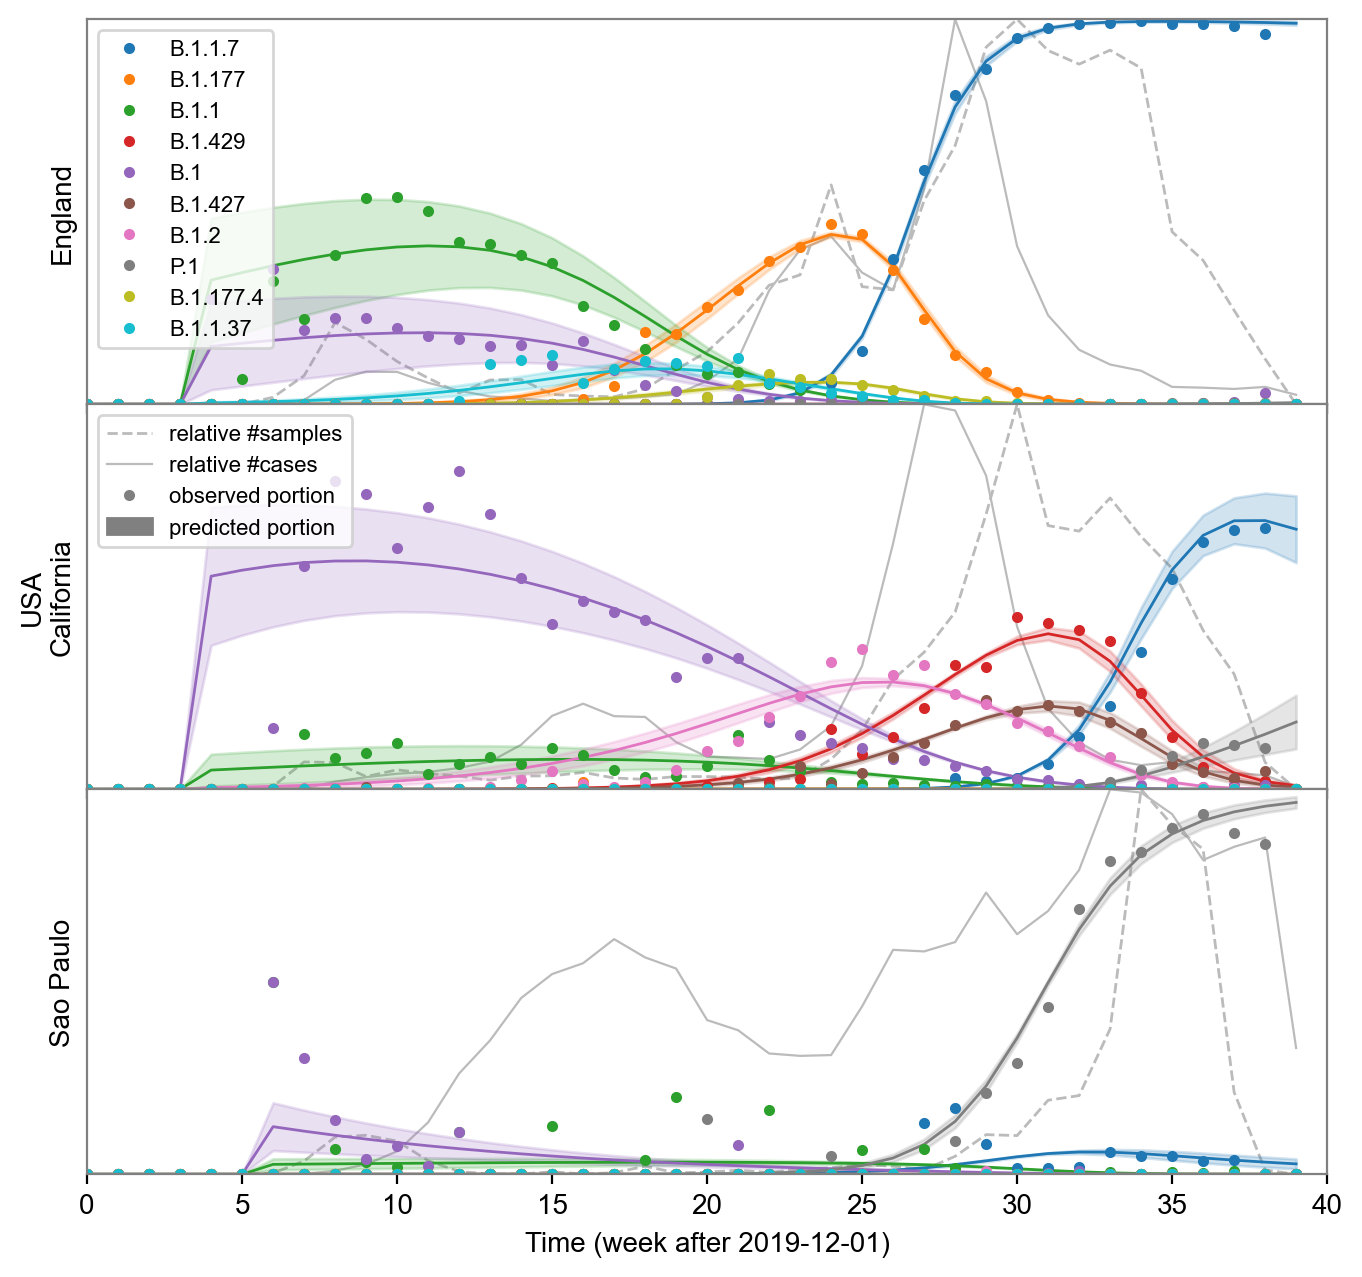

In [20]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

def plot_forecast(fit, queries=None, num_strains=10):
    if queries is None:
        queries = list(location_id)
    elif isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1.5 + 2 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    probs = plusminus(fit["mean"]["probs"], fit["std"]["probs"])
    predicted = probs * weekly_cases[:, :, None]  # [T, P, S]
    ids = torch.tensor([i for name, i in location_id.items()
                        if any(q in name for q in queries)])
    strain_ids = weekly_strains[:, ids].sum([0, 1]).sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    colors = [f"C{i}" for i in range(10)] + ["black"] * 90
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for name, i in location_id.items() if query in name])
        print(f"{query} matched {len(ids)} regions")
        counts = weekly_cases[:, ids].sum(1)
        counts /= counts.max()
        ax.plot(counts, "k-", color=light, lw=0.8, zorder=-20)
        counts = weekly_strains[:, ids].sum([1, 2])
        counts /= counts.max()
        ax.plot(counts, "k--", color=light, lw=1, zorder=-20)
        pred = predicted.index_select(-2, ids).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-8)
        obs = weekly_strains[:, ids].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        time = np.arange(len(local_time))
        for s, color in zip(strain_ids, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(time, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(mean, color=color, lw=1, zorder=-9)
            strain = lineage_id_inv[s]
            ax.plot(obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label={"Q": "B.1.1.7"}.get(strain, strain) if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_xlim(0, len(weekly_strains))
        if row == len(axes) - 1:
            ax.set_xlabel("Time (week after 2019-12-01)")
        if row == 0:
            ax.legend(loc="upper left", fontsize=8)
        elif row == 1:
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left", fontsize=8)
    plt.subplots_adjust(hspace=0)
plot_forecast(fit, queries)

In [ ]:
def plot_fit(fit):
    num_nonzero = int(torch.count_nonzero(weekly_strains))
    median = fit.get("median", fit.get("mean", {}))
    plt.figure(figsize=(8, 7))
    time = np.arange(1, 1 + len(fit["losses"]))
    plt.plot(fit["losses"], "k--", label="loss")
    locs = []
    grads = []
    for name, series in fit["series"].items():
        rankby = -torch.tensor(series).log1p().mean().item()
        if "Guide." in name:
            name = name.split("Guide.")[-1].replace("$$$", ".")
            grads.append((name, series, rankby))
        elif name != "loss":
            locs.append((name, series, rankby))
    locs.sort(key=lambda x: x[-1])
    grads.sort(key=lambda x: x[-1])
    for name, series, _ in locs:
        plt.plot(time, series, label=name)
    for name, series, _ in locs:
        plt.plot(time, series, color="white", lw=3, alpha=0.3, zorder=-1)
    for name, series, _ in grads:
        plt.plot(time, series, lw=1, alpha=0.5, label=name, zorder=-2)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(1, len(fit["losses"]))
    plt.legend(loc="upper left", fontsize=8)
    plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
    plt.title("L={:0.4g} C={:0.3g} M={:0.3g} F={:0.3g} P={:0.3g}"
    .format(
        np.median(fit["losses"][-201:]) / num_nonzero,
        float(median.get("concentration", math.inf)),
        float(median.get("mislabel", 0)),
        float(median["feature_scale"]),
        float(median.get("place_scale", 0)),
    ))
plot_fit(fit)

In [ ]:
fit = mutrans.fit_bootstrap(
    dataset,
    model_type="",
    guide_type="map",
    num_samples=10,
    num_steps=1001,
    learning_rate=0.05,
    learning_rate_decay=1.0,
)

In [ ]:
def plot_volcano(mean, std, linthresh=2, top_k=10):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    plt.text(0.2 * x0 + 0.8 * x1, p95 * 0.95, "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
        name = mutations[int(idx_neg[i])]
        plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
plot_volcano(fit["mean"]["rate_coef"], fit["std"]["rate_coef"], linthresh=2)